# 1b: Annual variability comparison plot

- shows the differences in the interannual regional volume variability between the glacier models
- in theory, in a very warm/cold year, all glacier models should have a similar signal and correlate. However, we found, that some glacier models correlate quite well among each others (OGGM, OGGM-VAS, PyGEM, GLIMB, JULES), while the GloGEM family does not correlate with the others, but also, e.g. GloGEM does not correlate with GloGEMFlow and so on ... 
- an even more clear signal is visible when comparing single glaciers --> `0_individual_glacier_check.ipynb`

---

In [1]:
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29'
path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
#path_merged_runs_scaled = '/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_apr04_models_all_rgi_regions_sum_scaled.nc'

---

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import oggm
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
dict_col = dict(zip(model_order, pal_models))


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
ds_reg_models = xr.open_dataset(path_merged_runs_scaled)

In [16]:
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
ds_reg_models = ds_reg_models.sel(model_author=glac_models)


In [17]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

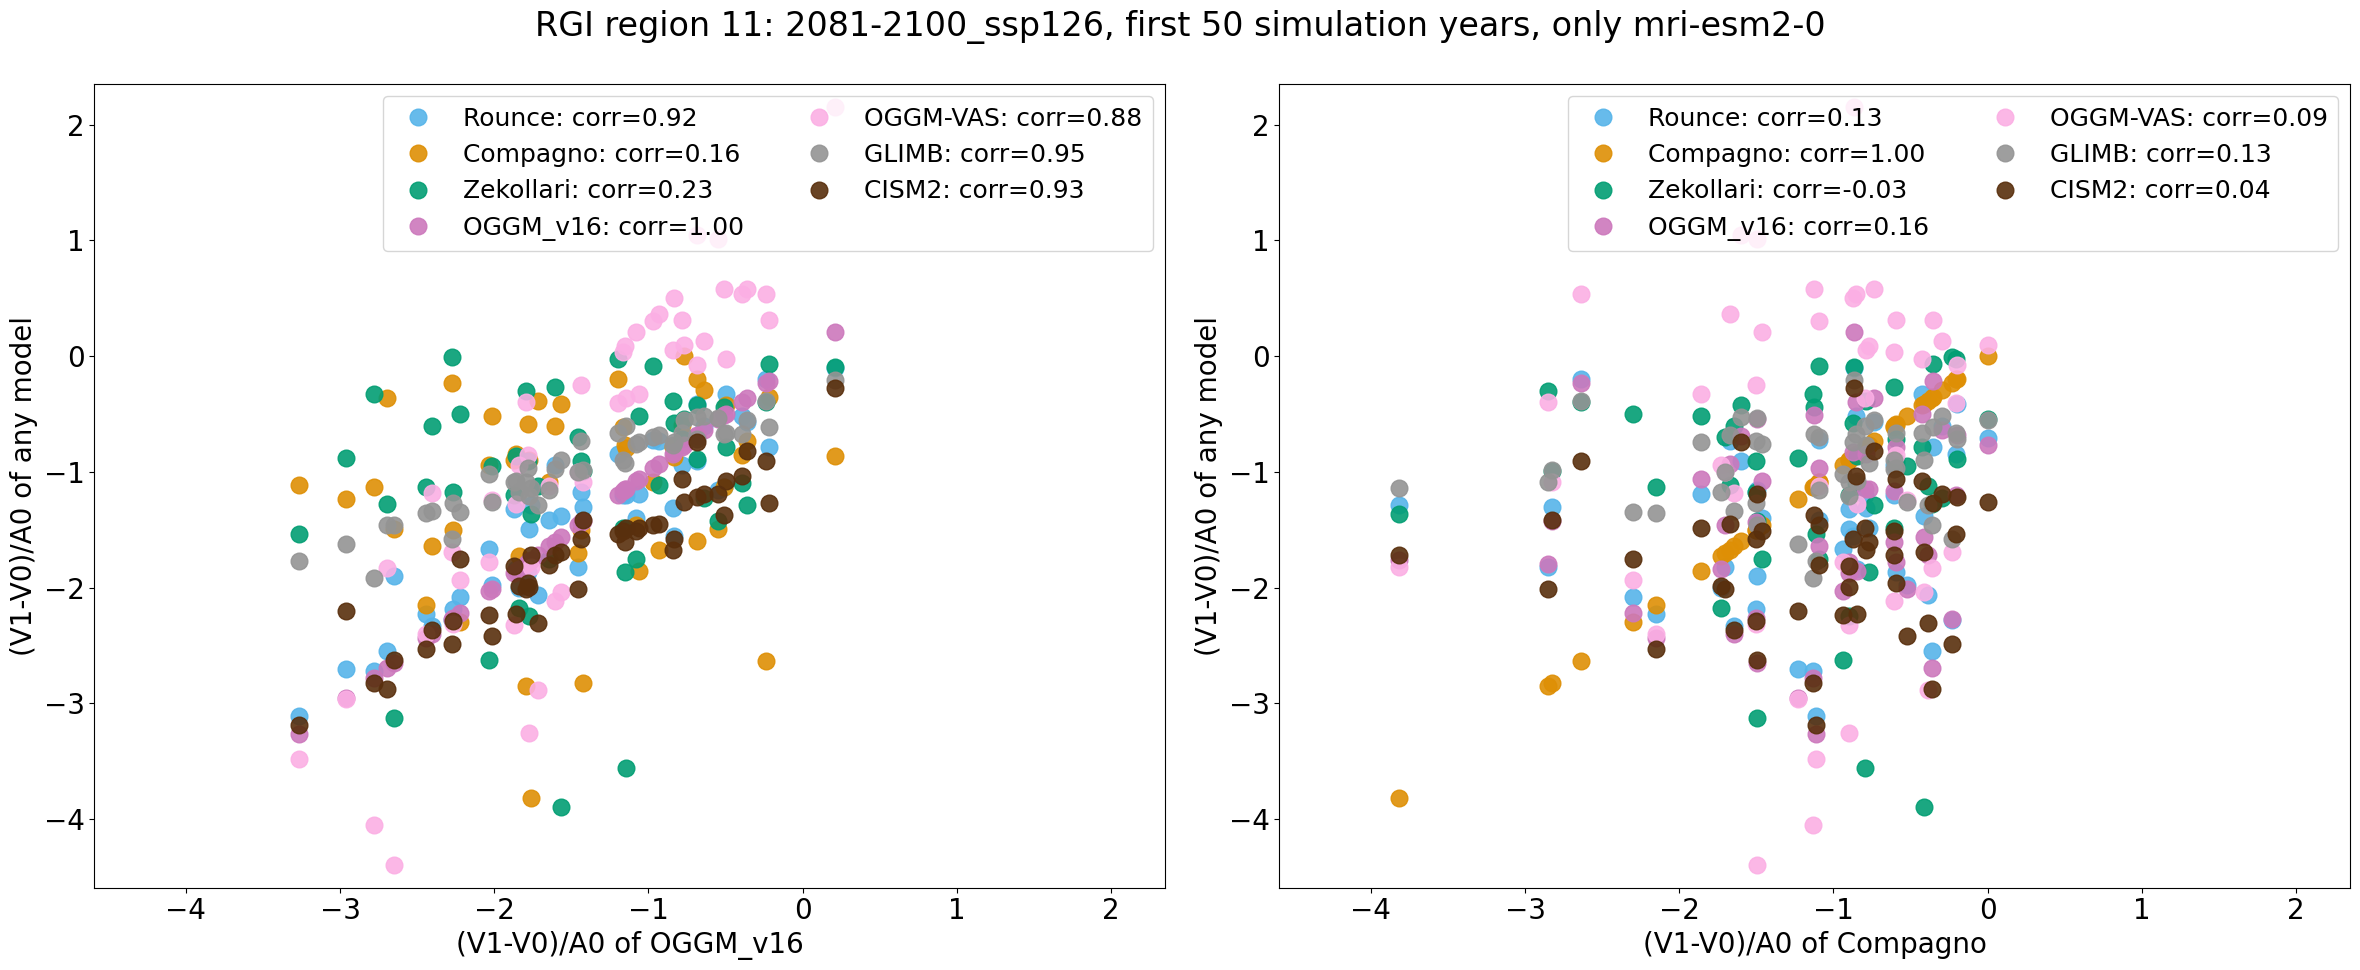

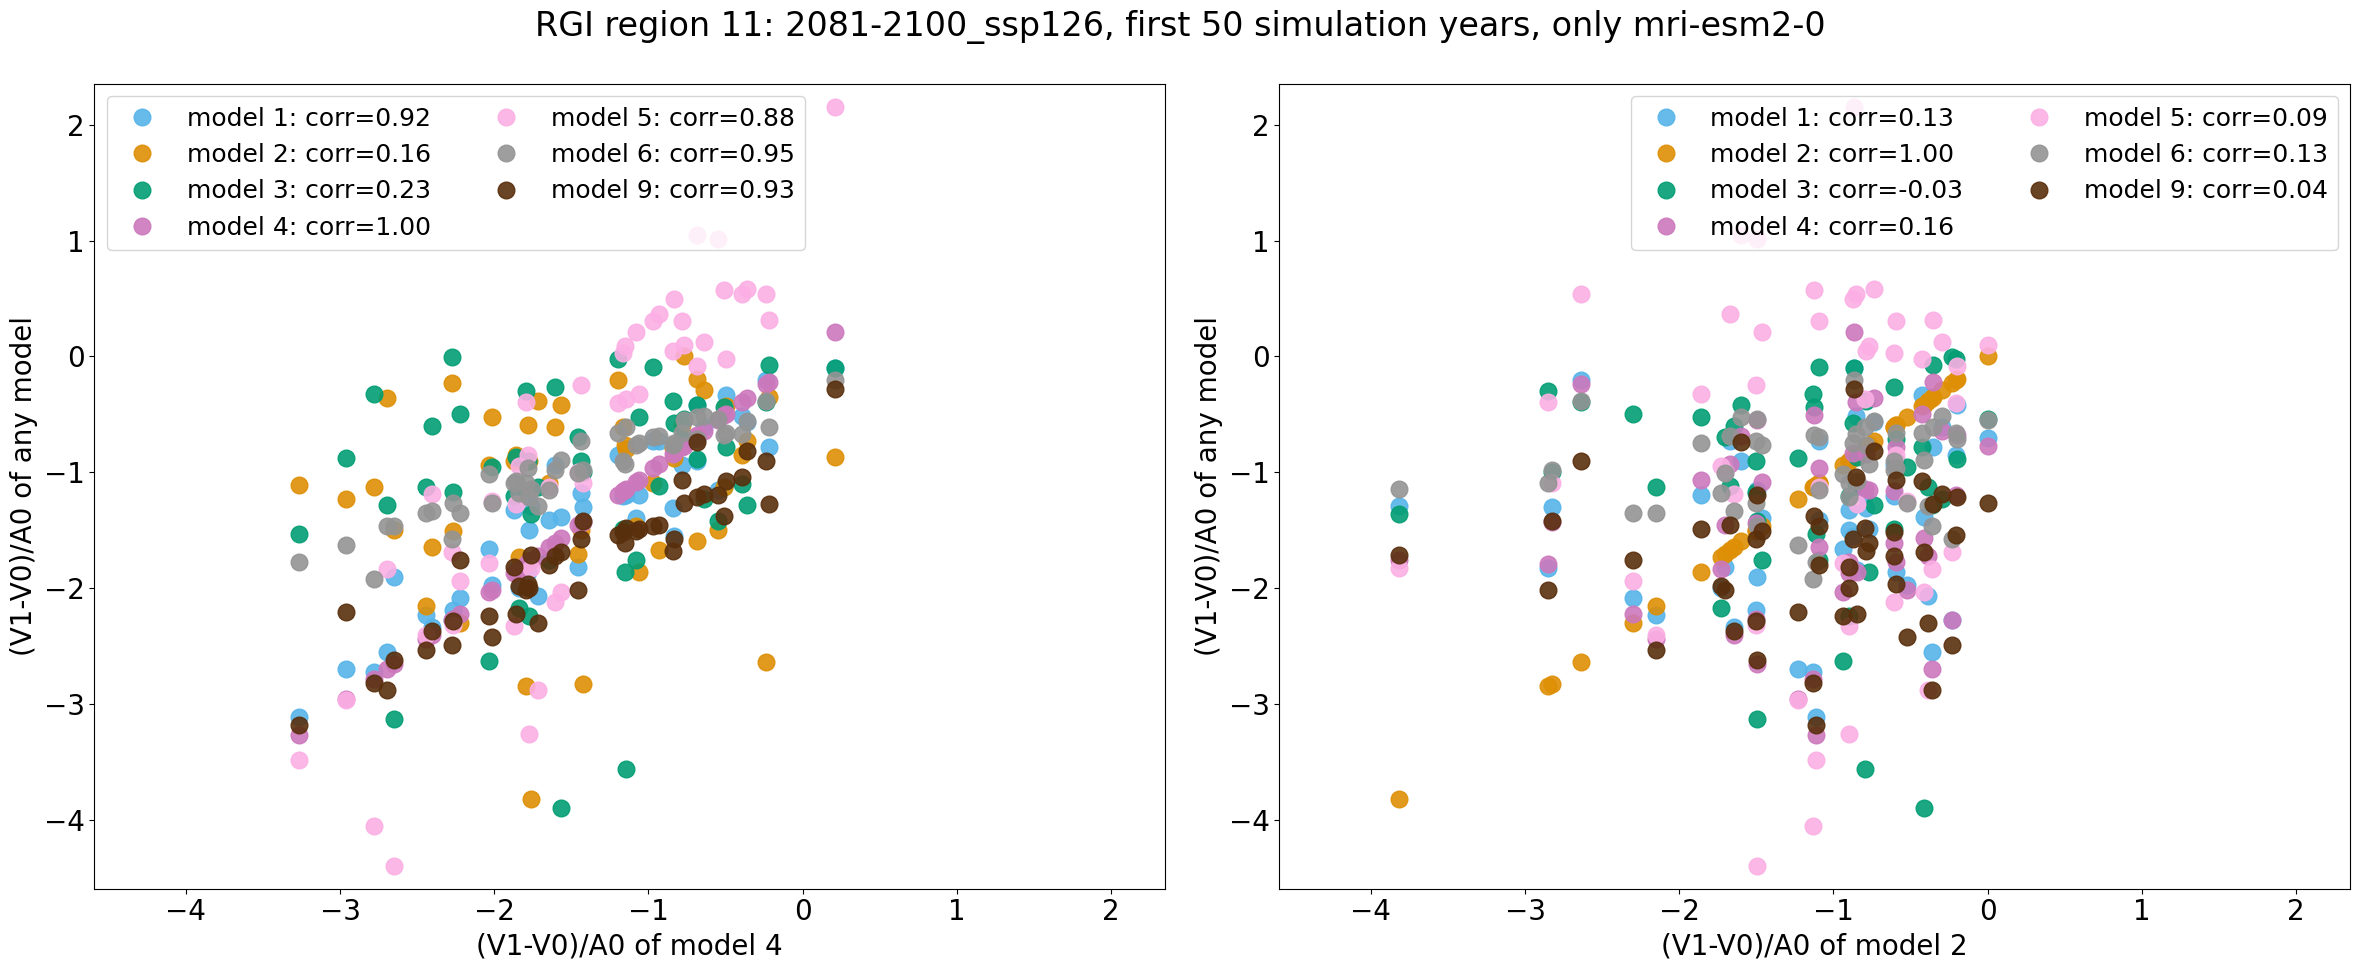

In [23]:
#period_scenario = '1851-1870_hist' #'2081-2100_ssp126'
period_scenario = '2081-2100_ssp126' #'1851-1870_hist' #'1901-1920_hist'
gcm = 'mri-esm2-0'
#gcm = 'gfdl-esm4'
#['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0',
#       'ukesm1-0-ll']

y1 = 50
ds_sel_0 = ds_reg_models.sel(simulation_year=slice(0,y1)).sel(gcm=gcm).sel(period_scenario=period_scenario)
for anonym in ['','_anonym']:
    for rgi_reg in rgi_regs:

        # let's first just takt the first 300 years
        ds_sel = ds_sel_0.sel(rgi_reg=rgi_reg)

        V0 = ds_sel.isel(simulation_year=slice(0,y1-1)).volume_m3
        A0 = ds_sel.isel(simulation_year=slice(0,y1-1)).area_m2.values
        V1 = ds_sel.isel(simulation_year=slice(1,y1)).volume_m3.values
        delta_scaled_V =  (V1-V0)/A0

        pd_delta_scaled_V = delta_scaled_V.to_dataframe('(V1-V0)/A0').reset_index().dropna()

        plt.rc('font', size=20)     
        plt.figure(figsize=(24,10))
        for j,ref_m in enumerate(['OGGM_v16', 'Compagno']):
            plt.subplot(1,2,j+1)
            for m in pd_delta_scaled_V.model_author.unique():
                t_x = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==ref_m,
                                            ['(V1-V0)/A0', 'simulation_year']]
                t = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==m,
                                            ['(V1-V0)/A0', 'simulation_year']]
                t_x = t_x.set_index('simulation_year')
                t = t.set_index('simulation_year')

                t.loc[t_x.index.values, f'(V1-V0)/A0_{ref_m}'] = t_x['(V1-V0)/A0']
                rcorr = t.corr()['(V1-V0)/A0'][f'(V1-V0)/A0_{ref_m}']
                if anonym == '_anonym':
                    m_l = model_order_anonymous[m]
                    ref_m_l = model_order_anonymous[ref_m]
                else:
                    m_l = m
                    ref_m_l =ref_m
                plt.plot(t[f'(V1-V0)/A0_{ref_m}'], t['(V1-V0)/A0'],
                        'o', color = dict_col[m], label=f'{m_l}: corr={rcorr:.2f}', markersize=12, alpha = 0.9)
            plt.ylabel('(V1-V0)/A0 of any model')
            plt.xlabel(f'(V1-V0)/A0 of {ref_m_l}')
            plt.legend(ncol=2, fontsize=18)
            plt.ylim([pd_delta_scaled_V['(V1-V0)/A0'].min()-0.2,
                      pd_delta_scaled_V['(V1-V0)/A0'].max()+0.2])
            plt.xlim([pd_delta_scaled_V['(V1-V0)/A0'].min()-0.2,
                      pd_delta_scaled_V['(V1-V0)/A0'].max()+0.2])
        plt.suptitle( f'RGI region {rgi_reg}: '
                     + period_scenario+ f', first {y1} simulation years, only {str(ds_sel.gcm.values)}')
        plt.tight_layout()
        plt.savefig(f'figures/1b_annual_variability/1_model_corr_{rgi_reg}_{period_scenario}_{gcm}{anonym}.png')
        if rgi_reg != '11':
            plt.close()

### Some other plots showing a similar thing:

In [49]:
load = True
if load:
    y1 = 50
    rcorr_l = []
    ref_m_l = []
    rgi_reg_l = []
    model_l = []
    period_scenario_l = []
    gcm_l = []
    for gcm in ds_reg_models.gcm.values:
        ds_sel_00 = ds_reg_models.sel(simulation_year=slice(0,y1)).sel(gcm=gcm)
        for j,ref_m in enumerate(['OGGM_v16', 'Compagno']):
            for period_scenario in ds_sel_00.period_scenario.values:
                ds_sel_0 = ds_sel_00.sel(period_scenario=period_scenario)
                for rgi_reg in rgi_regs:

                    # let's first just takt the first 300 years
                    ds_sel = ds_sel_0.sel(rgi_reg=rgi_reg).dropna(dim='model_author')

                    V0 = ds_sel.sel(simulation_year=slice(0,y1-1)).volume_m3
                    A0 = ds_sel.sel(simulation_year=slice(0,y1-1)).area_m2.values
                    V1 = ds_sel.sel(simulation_year=slice(1,y1)).volume_m3.values
                    delta_scaled_V =  ((V1-V0)/A0).dropna(dim='simulation_year') # in some regions 
                    if len(delta_scaled_V.simulation_year)<50:
                        print( len(delta_scaled_V.simulation_year))
                    pd_delta_scaled_V = delta_scaled_V.to_dataframe('(V1-V0)/A0').reset_index().dropna()

                    for m in pd_delta_scaled_V.model_author.unique():
                        if m == ref_m:
                            pass
                        else:
                            t_x = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==ref_m,
                                                        ['(V1-V0)/A0', 'simulation_year']]
                            t = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==m,
                                                        ['(V1-V0)/A0', 'simulation_year']]
                            t_x = t_x.set_index('simulation_year')
                            t = t.set_index('simulation_year')

                            t.loc[t_x.index.values, f'(V1-V0)/A0_{ref_m}'] = t_x['(V1-V0)/A0']
                            rcorr = t.corr()['(V1-V0)/A0'][f'(V1-V0)/A0_{ref_m}']
                            rcorr_l.append(rcorr)
                            model_l.append(m)
                            rgi_reg_l.append(rgi_reg)
                            ref_m_l.append(ref_m)
                            period_scenario_l.append(period_scenario)
                            gcm_l.append(gcm)


    pd_corr = pd.DataFrame()
    pd_corr['model'] = model_l
    pd_corr['rgi_reg'] = rgi_reg_l
    pd_corr['rcorr'] = rcorr_l
    pd_corr['ref_m'] = ref_m_l
    pd_corr['period_scenario'] = period_scenario_l
    pd_corr['gcm'] = gcm_l
    
pd_corr['period_scenario_gcm'] = pd_corr['period_scenario'] + '_' + pd_corr['gcm']
    



44
44


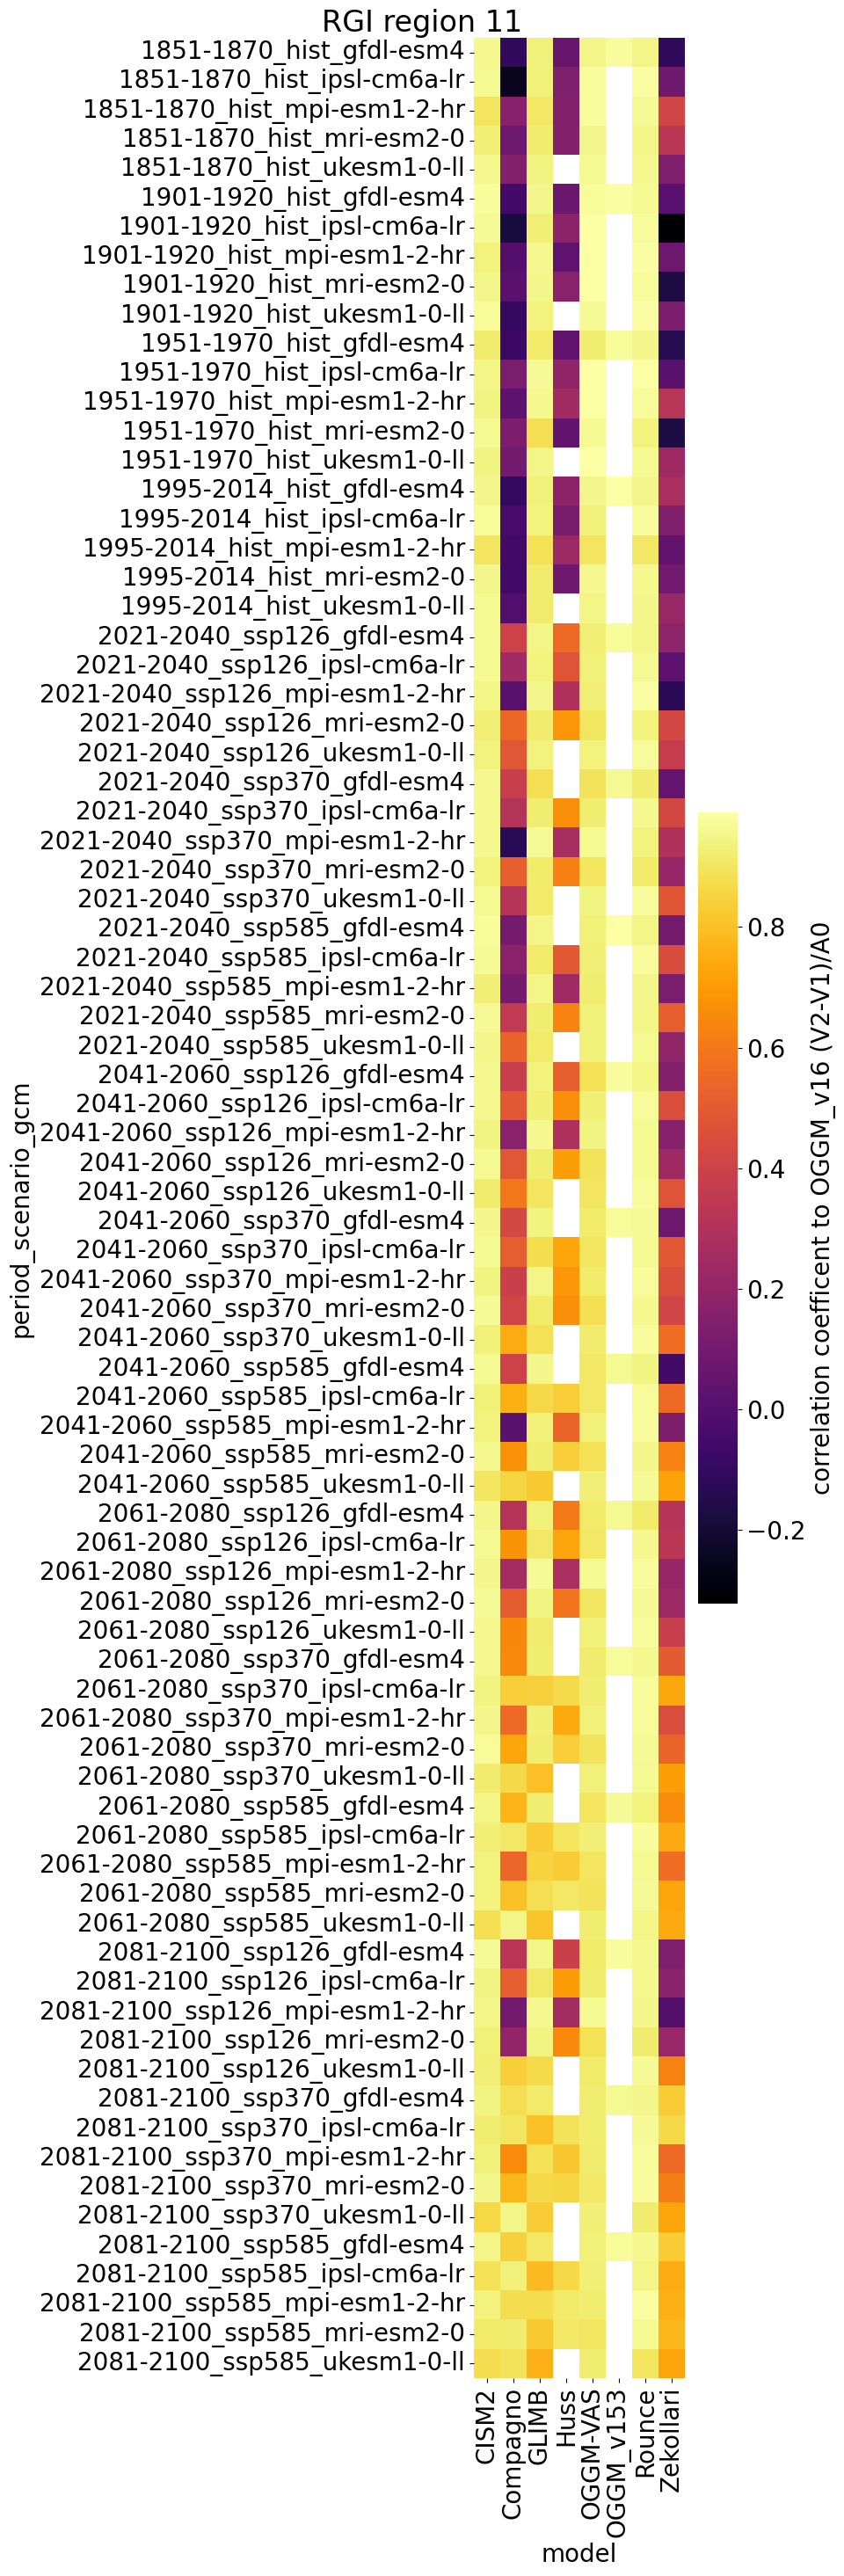

In [63]:
for rgi_reg in ['11']:
    pd_corr_sel = pd_corr.loc[pd_corr.ref_m == 'OGGM_v16']
    pd_corr_gcm_reg = pd_corr_sel.loc[pd_corr_sel.rgi_reg==rgi_reg]
    plt.figure(figsize=(10,30))
    plt.suptitle(f'RGI region {rgi_reg}')
    sns.heatmap(pd_corr_gcm_reg[['model','period_scenario_gcm',
                                 'rcorr']].pivot(columns='model', index='period_scenario_gcm', values='rcorr'), 
               cmap='inferno', cbar_kws = {'label':'correlation coefficent to OGGM_v16 (V2-V1)/A0'})
    plt.tight_layout()

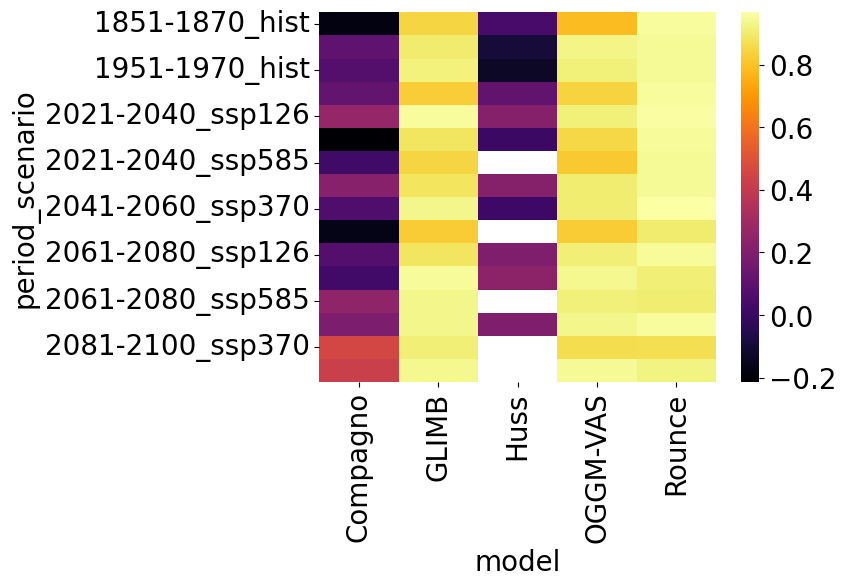

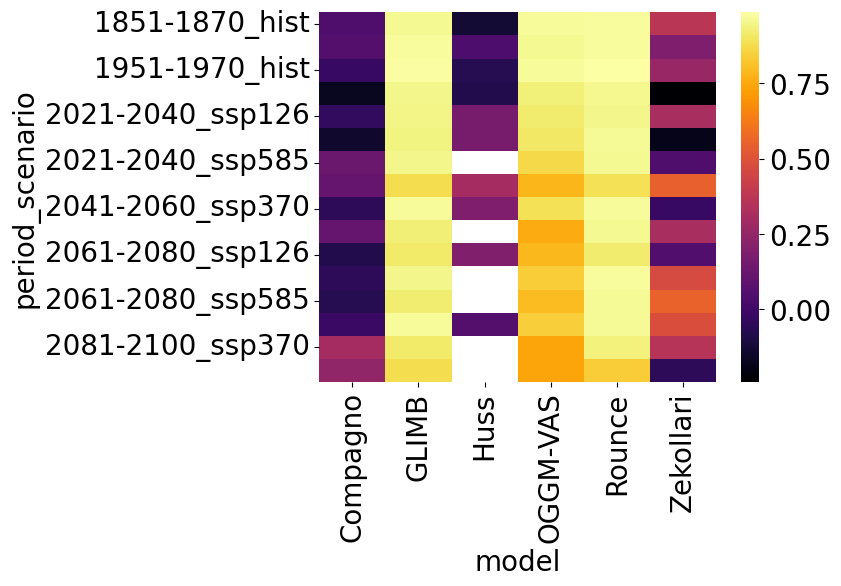

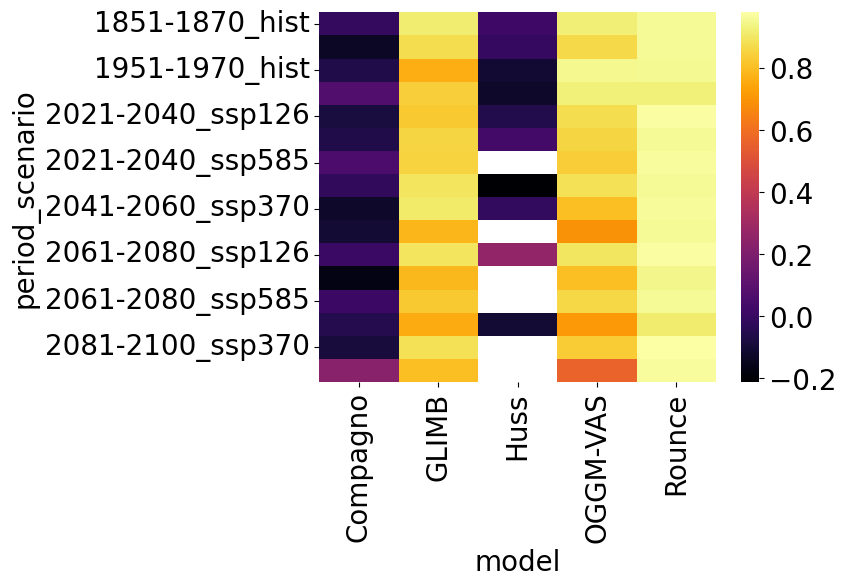

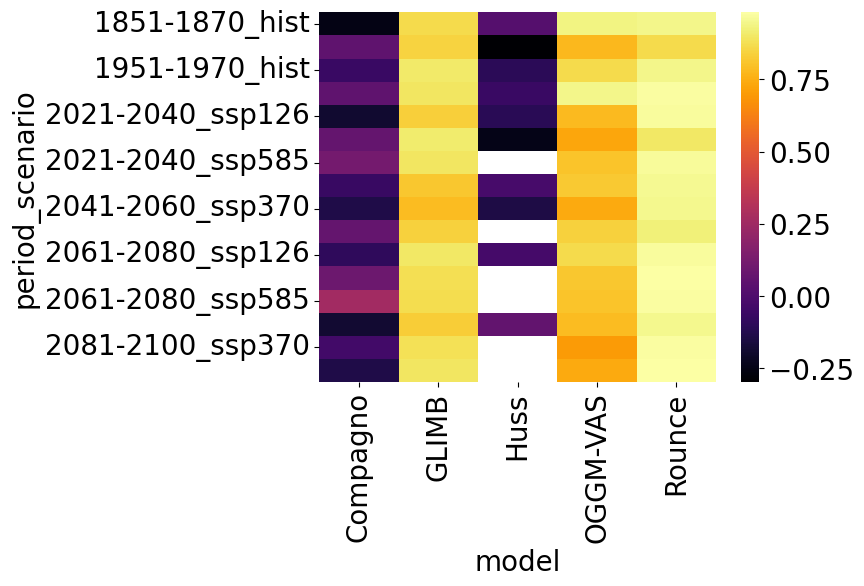

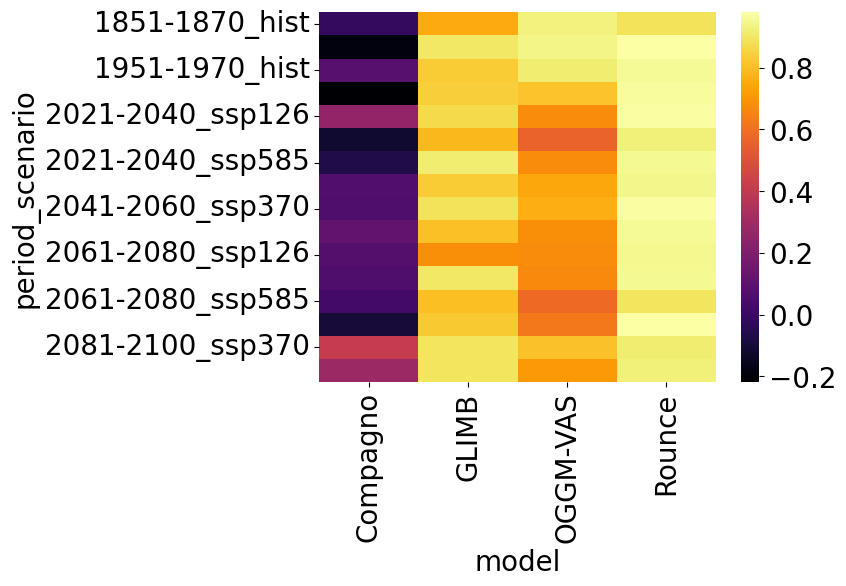

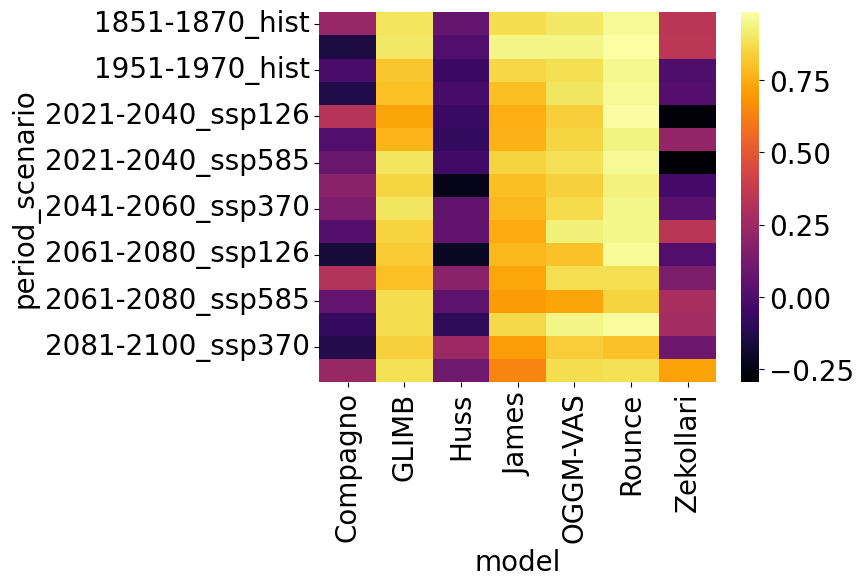

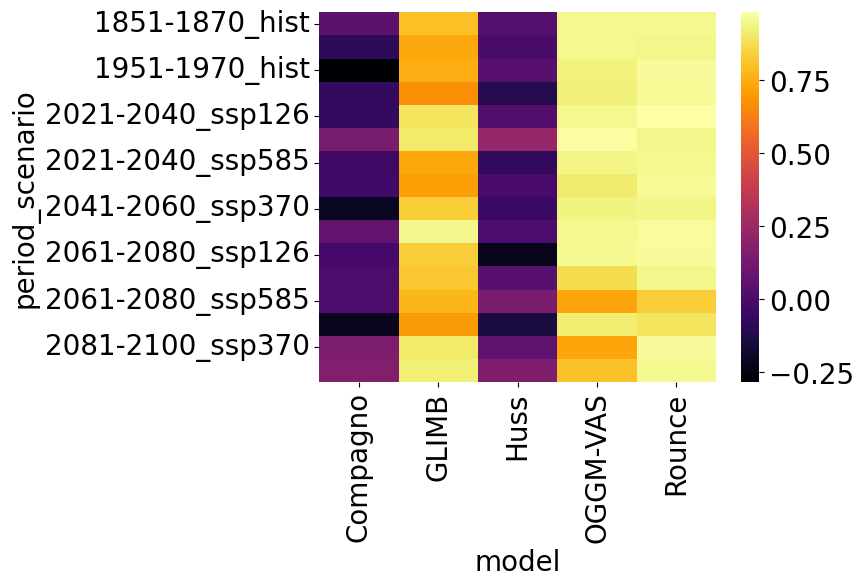

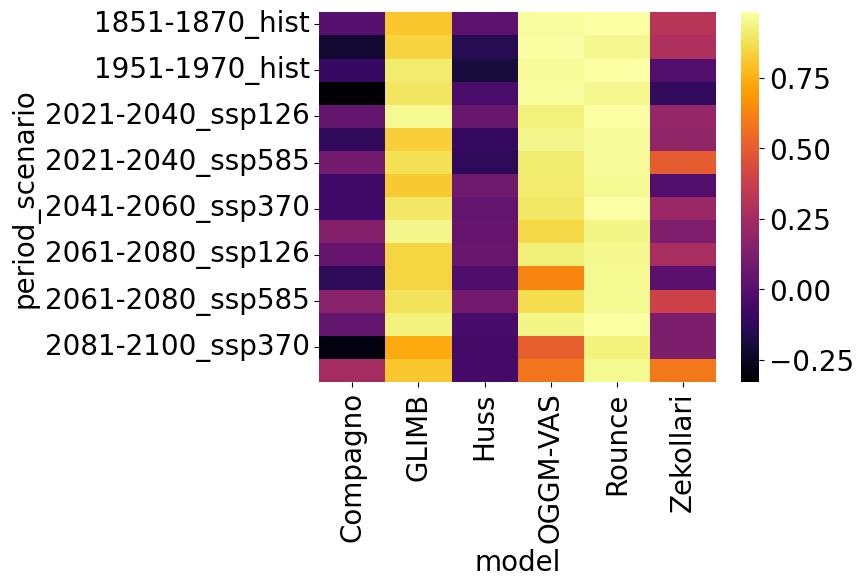

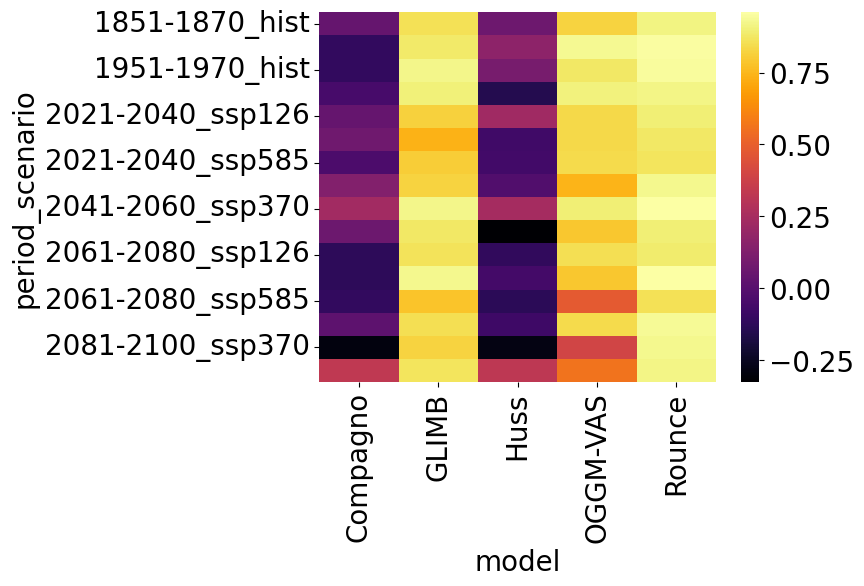

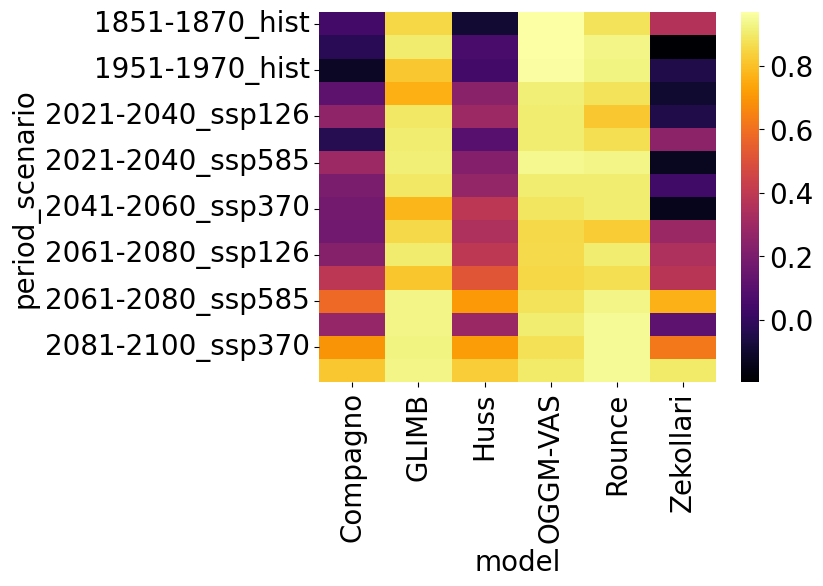

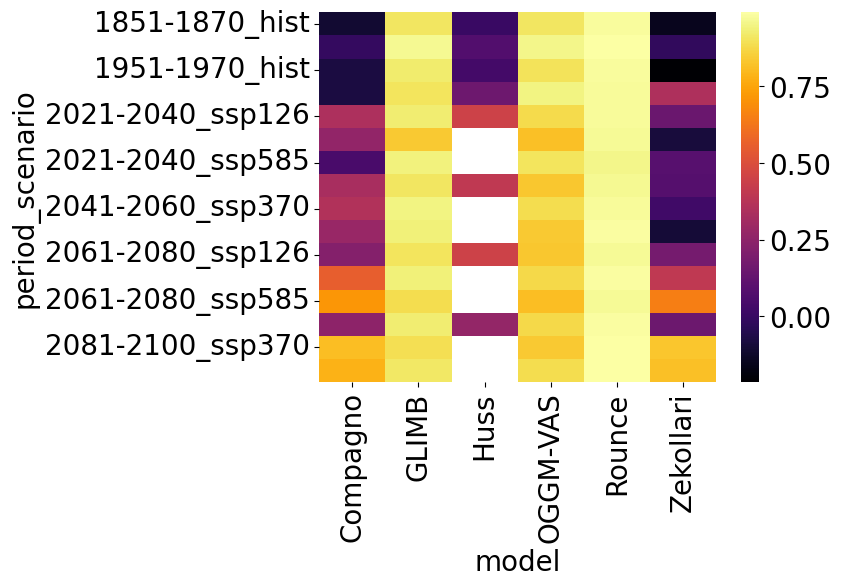

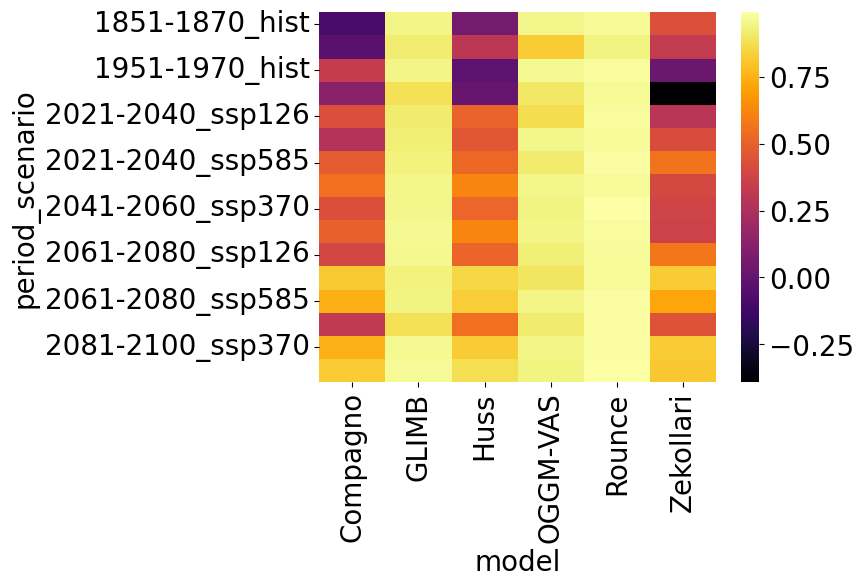

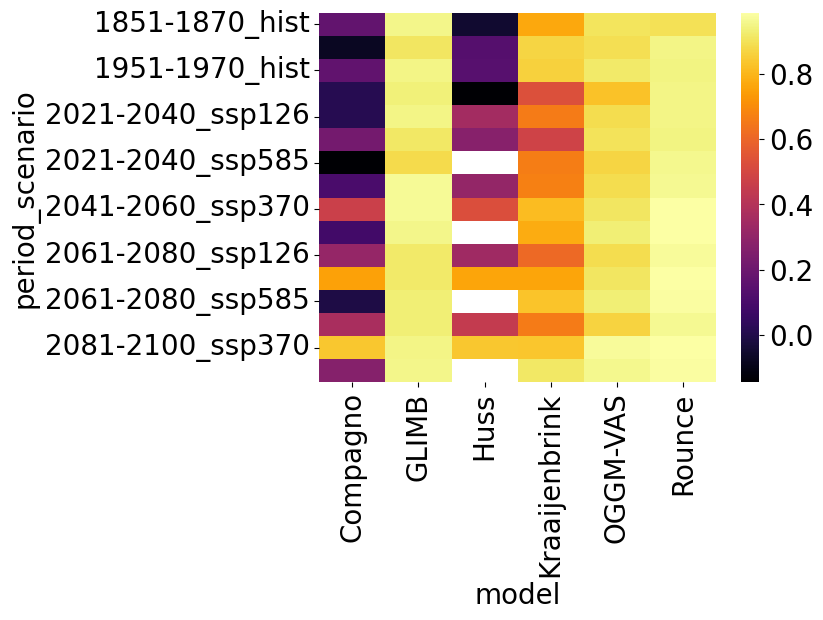

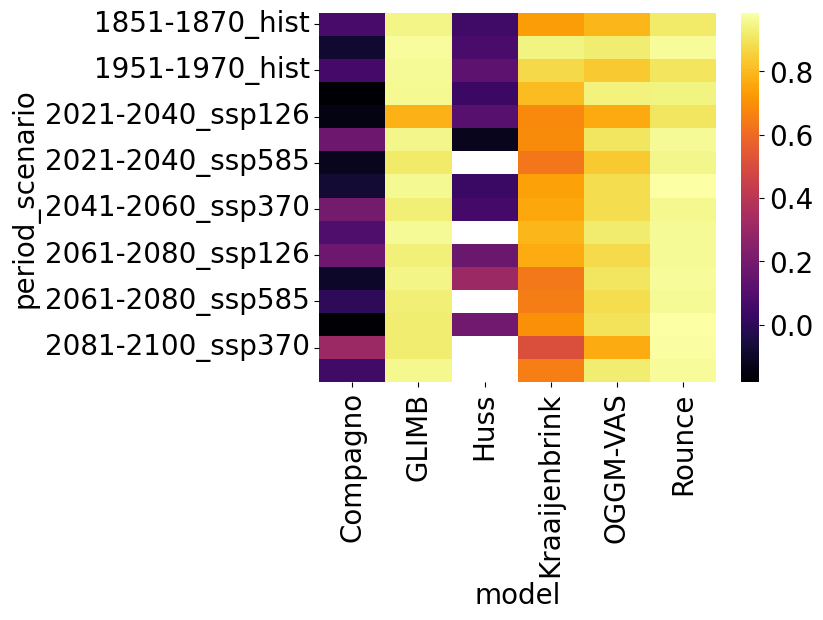

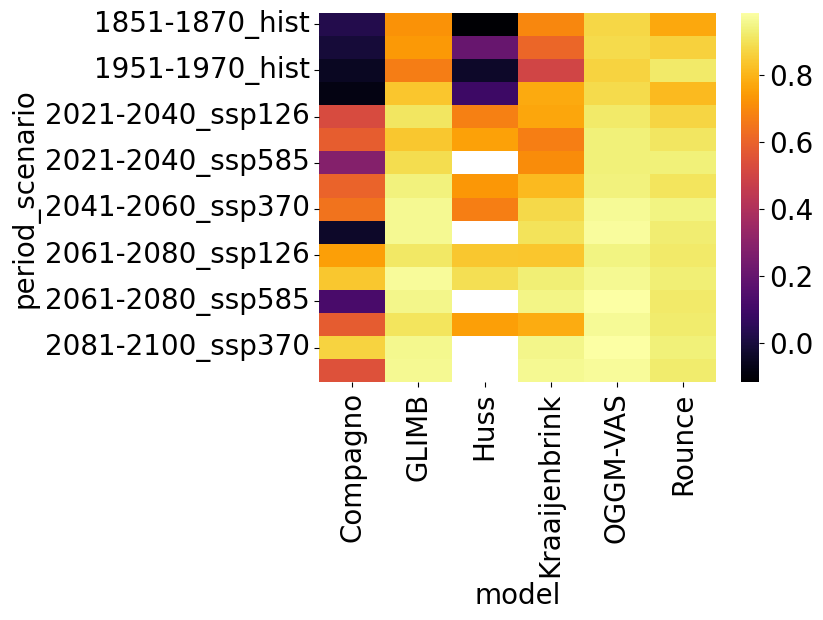

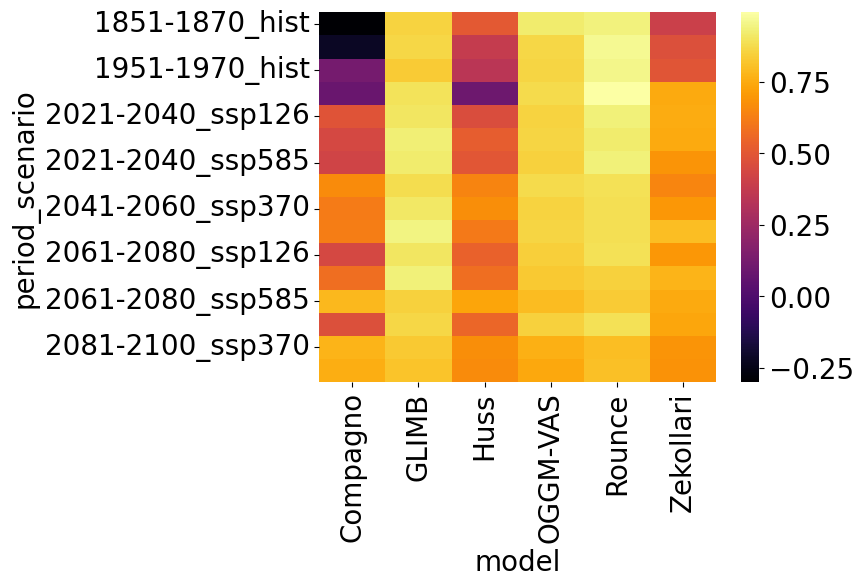

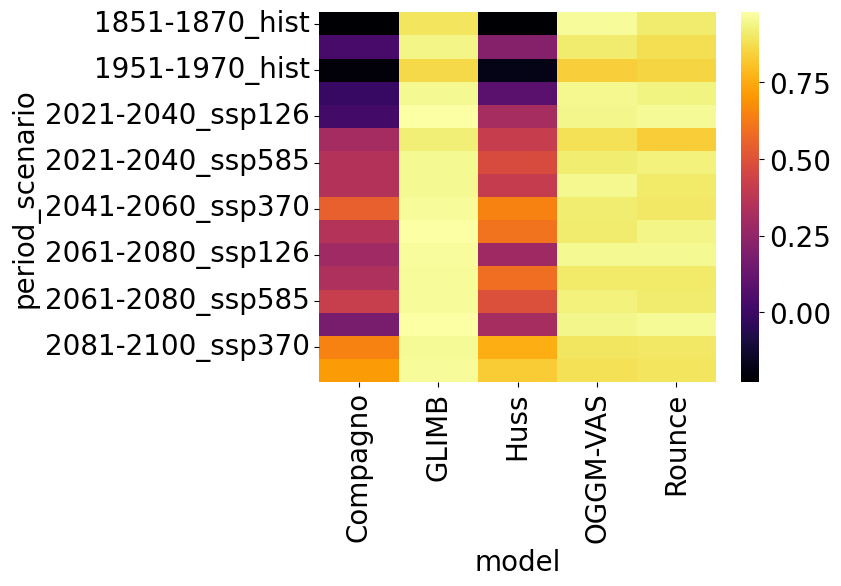

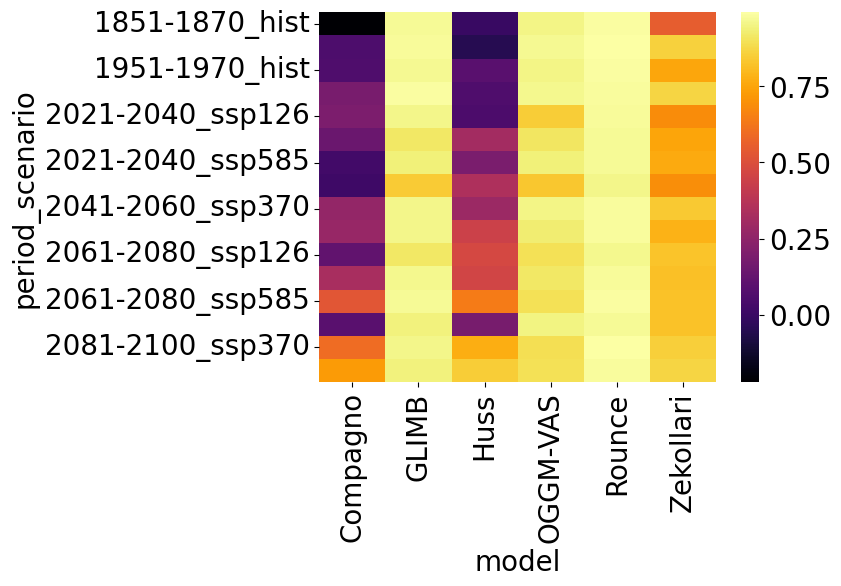

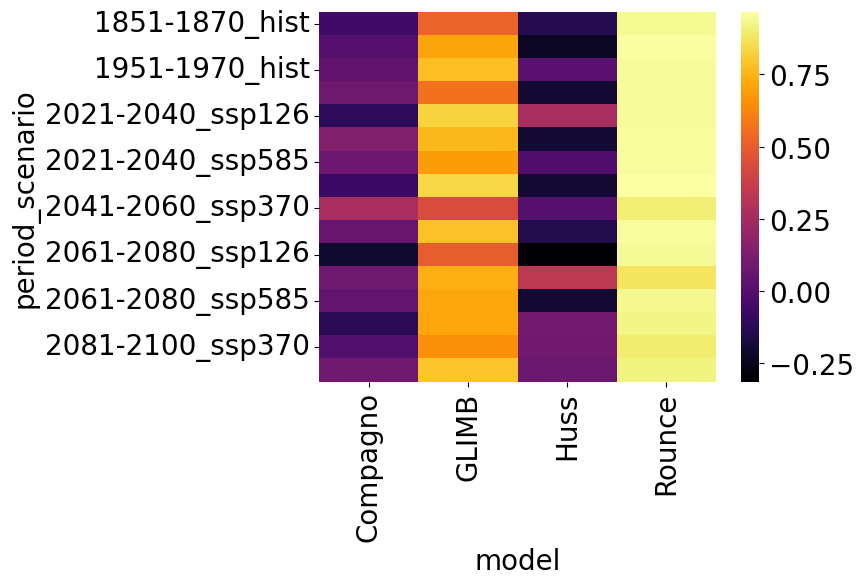

In [72]:
for rgi_reg in rgi_regs:

    pd_corr_gcm_reg = pd_corr_gcm.loc[pd_corr_gcm.rgi_reg==rgi_reg]
    plt.figure()
    sns.heatmap(pd_corr_gcm_reg[['model','period_scenario',
                                 'rcorr']].pivot(columns='model', index='period_scenario', values='rcorr'), 
               cmap='inferno')

## With offsets:

In [ ]:
load = True
if load:
    y1 = 50
    rcorr_l = []
    ref_m_l = []
    rgi_reg_l = []
    model_l = []
    period_scenario_l = []
    gcm_l = []
    for gcm in ['gfdl-esm4']: #ds_reg_models.gcm.values:
        ds_sel_00 = ds_reg_models.sel(simulation_year=slice(0,y1)).sel(gcm=gcm)
        for j,ref_m in enumerate(['OGGM_v153', 'Compagno']):
            for period_scenario in ds_sel_00.period_scenario.values:
                ds_sel_0 = ds_sel_00.sel(period_scenario=period_scenario)
                for rgi_reg in rgi_regs:

                    # let's first just takt the first 300 years
                    ds_sel = ds_sel_0.sel(rgi_reg=rgi_reg)
                    if ref_m == 'Compagno':
                        offset=19
                    else:
                        offset = 0
                    V0 = ds_sel.isel(simulation_year=slice(0+offset,y1-1+offset)).volume_m3
                    A0 = ds_sel.isel(simulation_year=slice(0+offset,y1-1+offset)).area_m2.values
                    V1 = ds_sel.isel(simulation_year=slice(1+offset,y1+offset)).volume_m3.values
                    delta_scaled_V =  (V1-V0)/A0

                    pd_delta_scaled_V = delta_scaled_V.to_dataframe('(V1-V0)/A0').reset_index().dropna()

                    for m in pd_delta_scaled_V.model_author.unique():
                        if m == ref_m:
                            pass
                        else:
                            t_x = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==ref_m,
                                                        ['(V1-V0)/A0', 'simulation_year']]
                            t = pd_delta_scaled_V.loc[pd_delta_scaled_V.model_author==m,
                                                        ['(V1-V0)/A0', 'simulation_year']]
                            t_x = t_x.set_index('simulation_year')
                            t = t.set_index('simulation_year')

                            t.loc[t_x.index.values, f'(V1-V0)/A0_{ref_m}'] = t_x['(V1-V0)/A0']
                            rcorr = t.corr()['(V1-V0)/A0'][f'(V1-V0)/A0_{ref_m}']
                            rcorr_l.append(rcorr)
                            model_l.append(m)
                            rgi_reg_l.append(rgi_reg)
                            ref_m_l.append(ref_m)
                            period_scenario_l.append(period_scenario)
                            gcm_l.append(gcm)


    pd_corr = pd.DataFrame()
    pd_corr['model'] = model_l
    pd_corr['rgi_reg'] = rgi_reg_l
    pd_corr['rcorr'] = rcorr_l
    pd_corr['ref_m'] = ref_m_l
    pd_corr['period_scenario'] = period_scenario_l
    pd_corr['gcm'] = gcm_l
    
pd_corr_gcm = pd_corr.loc[pd_corr.gcm==gcm]
pd_corr_gcm = pd_corr_gcm.loc[pd_corr_gcm.ref_m == 'OGGM_v153']


for rgi_reg in rgi_regs:

    pd_corr_gcm_reg = pd_corr_gcm.loc[pd_corr_gcm.rgi_reg==rgi_reg]
    plt.figure()
    sns.heatmap(pd_corr_gcm_reg[['model','period_scenario',
                                 'rcorr']].pivot(columns='model', index='period_scenario', values='rcorr'), 
               cmap='inferno')

## Old Random stuff

In [ ]:
sns.heatmap(x='rgi_reg', y='rcorr', hue='model', kind='strip',
            palette=pal_models, data=pd_corr, col='gcm')

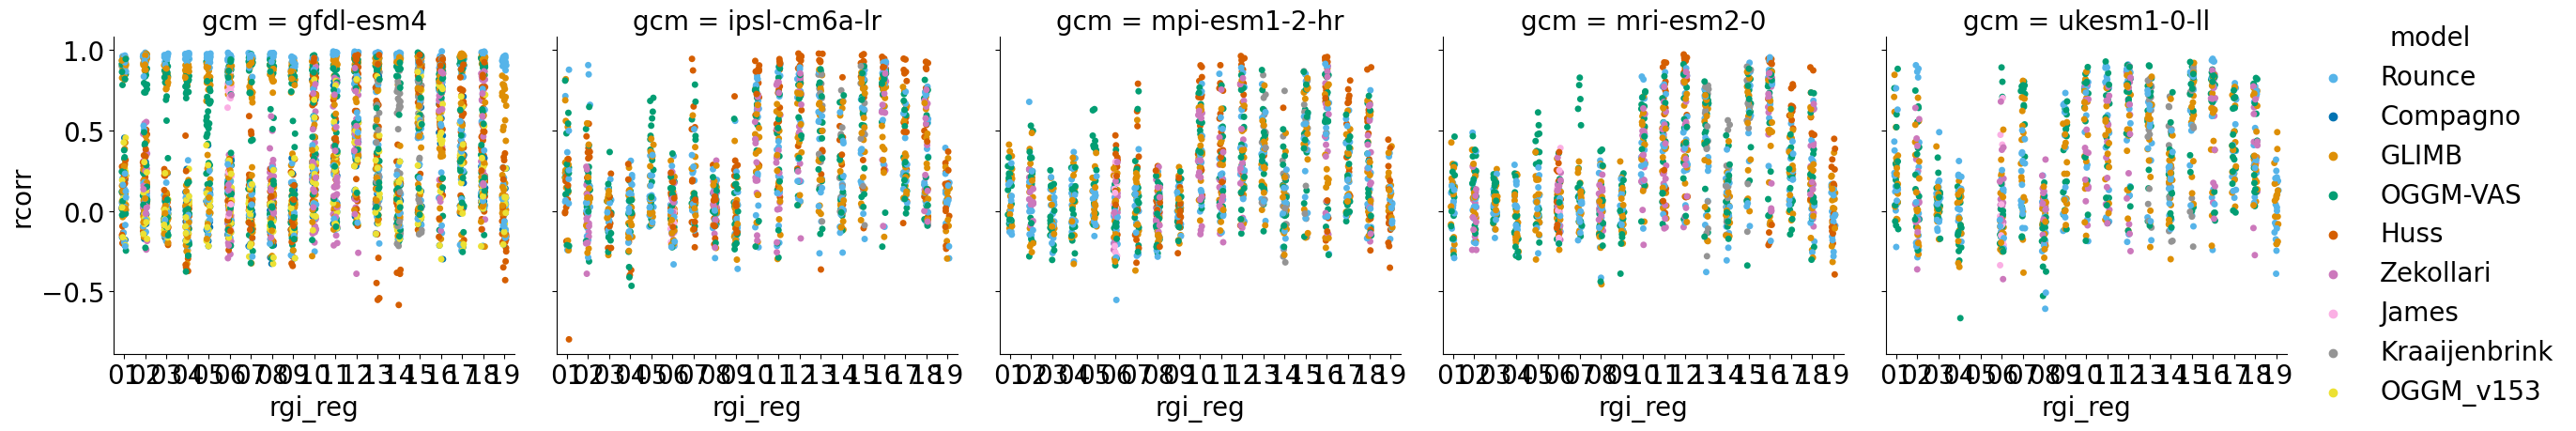

In [37]:
sns.catplot(x='rgi_reg', y='rcorr', hue='model', kind='strip',
            palette=pal_models, data=pd_corr, col='gcm')

<AxesSubplot:xlabel='simulation_year', ylabel='(V1-V0)/A0'>

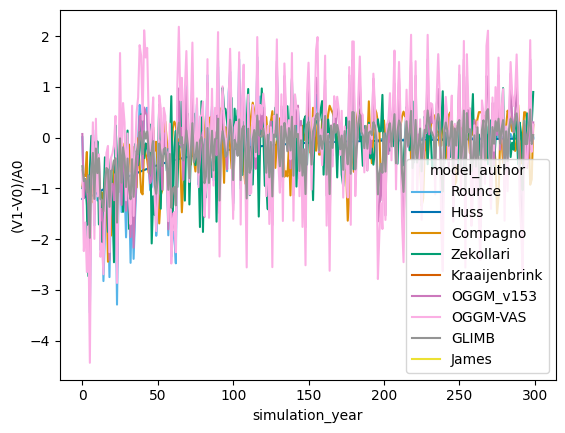

In [61]:
sns.lineplot(x='simulation_year',
             y='(V1-V0)/A0',
             data=pd_delta_scaled_V, hue='model_author', hue_order=model_order, palette=pal_models)